# Running main toy examples for article:

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from acpi import ACPI
from lcv.scores import RegressionScore, LocalRegressionScore
import time


from lcv.locart import LocartSplit, MondrianRegressionSplit
from lcv.scores import RegressionScore
from lcv.simulation import toy_simulation
from lcv.utils import compute_interval_length, split, real_coverage, smis
from lcv.valid_pred_sets import Valid_pred_sets

original_path = os.getcwd()

# figure path
images_dir = "figures"

Plotting simulated data to test distribution:

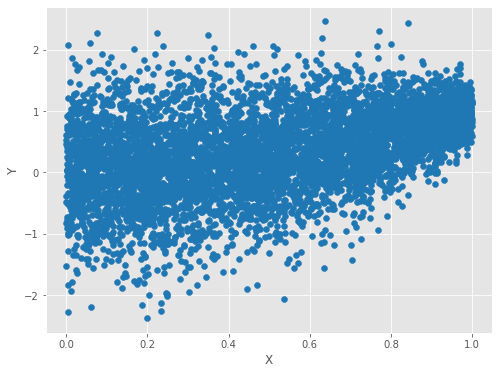

In [2]:
sim_obj = toy_simulation(hetero_value = 1.05, xlim = 1)
sim_obj.bimodal(n = 20000)
sim_data = split(sim_obj.X, sim_obj.y)
plt.figure(figsize=(8,6))
plt.scatter(sim_data["X_train"][:, 0], y = sim_data["y_train"], color = "tab:blue")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [20]:
# run toy example for all 
def run_toy_example(
    kind = "bimodal",
    n = 25000,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2,
    calib_size = 0.5,
    nbins = 30,
    coef = 1,
    hetero_value = 1.05,
    asym_value = 0.6,
    x_lim = 1,
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    split_calib = True,
    plot_tree = True,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 150,
    prune = True,
    weighting = True,
    tune_knn = True,
    **kwargs):
    # generating X_test

    sim_obj = toy_simulation(coef = coef, hetero_value = hetero_value, asym_value = asym_value, xlim = x_lim)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n = n, random_seed = random_seed_X)
    data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)
    r_kind = getattr(sim_obj, kind + "_r")
    np.random.seed(random_seed)
    X_test = np.random.uniform(low = 0, high = x_lim, size = (B_x, 1))
    y_mat = r_kind(X_test, B = B_y)

    X_grid = np.linspace(0, x_lim, 1000)
    y_grid = r_kind(X_grid, B = B_y)

    # tuning knn
    if tune_knn:
        grid_params = {'n_neighbors' : [5, 10, 15, 20, 25, 30, 35, 40, 45, 
                                        50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
                                        105, 110, 115, 120, 125, 130, 135, 140, 150],
               'weights' : ['uniform','distance']}
        gs = GridSearchCV(base_model(), grid_params, cv = 5, n_jobs = -1, scoring = "neg_mean_absolute_error")
        g_res = gs.fit(data["X_train"], data["y_train"])
        params = g_res.best_params_
        print("Best KNN params: {}".format(params))
        model = base_model(**params)
    else:
        model = base_model(**kwargs)
    model.fit(data["X_train"], data["y_train"])
        

    # fitting locart
    print("Fitting locart to toy example:")
    start_loc = time.time()
    loforest_obj = LocartSplit(nc_score = RegressionScore, base_model = model, cart_type = "RF", alpha = sig, split_calib = split_calib, is_fitted = True,
                             weighting = weighting, **kwargs)
    loforest_obj.fit(data["X_train"], data["y_train"])
    loforest_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    loforest_pred = np.array(loforest_obj.predict(data["X_test"]))
    loforest_pred_cond = np.array(loforest_obj.predict(X_test))
    cond_loforest_real = real_coverage(loforest_pred_cond, y_mat)

    # average, median and max distance
    dif_loforest = np.abs(cond_loforest_real - (1 - sig))
    loforest_ave_dist = np.mean(dif_loforest)

    # smis
    loforest_smis = smis(loforest_pred, data["y_test"], alpha = sig)

    # mean interval length
    loforest_interval_len = np.mean(compute_interval_length(loforest_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= loforest_pred[:, 0], 
        data["y_test"] <= loforest_pred[:, 1]) + 0
    loforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    loforest_interval_len_cover = np.mean(compute_interval_length(loforest_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting locart
    print("Fitting locart to toy example:")
    start_loc = time.time()
    locart_obj = LocartSplit(nc_score = RegressionScore, base_model = model, cart_type = "CART", alpha = sig, split_calib = split_calib, is_fitted = True,
                             weighting = weighting, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"]))
    locart_pred_cond = np.array(locart_obj.predict(X_test))
    cond_locart_real = real_coverage(locart_pred_cond, y_mat)

    # average, median and max distance
    dif_locart = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist = np.mean(dif_locart)

    # smis
    locart_smis = smis(locart_pred, data["y_test"], alpha = sig)

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)
    icp_pred_cond = icp.predict(X_test, significance = sig)
    cond_icp_real = real_coverage(icp_pred_cond, y_mat)
    
    # average, median and max distance
    dif_icp = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist = np.mean(dif_icp)

    # icp smis
    icp_smis = smis(icp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(model, alpha = sig, is_fitted = True, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])
    wicp_pred_cond = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred_cond, y_mat)
    
    
    wicp_dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist = np.mean(wicp_dif)

    # smis
    wicp_smis = smis(wicp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

    # mondrian split
    print("Fitting mondrian regression split")
    start_weighted_split = time.time()
    micp = MondrianRegressionSplit(model, alpha = sig, k = nbins, is_fitted = True, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit mondrian regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    micp_pred = micp.predict(data["X_test"])
    micp_pred_cond = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred_cond, y_mat)
    
    
    micp_dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist = np.mean(micp_dif)

    # smis
    micp_smis = smis(micp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


    all_results =  pd.DataFrame(data = {"Methods":["LOFOREST", "LOCART", "Regresion split", "Weighted regression split", "Mondrian"],
        "smis":[loforest_smis, locart_smis, icp_smis, wicp_smis, micp_smis],
        "Average marginal coverage":[loforest_ave_marginal_cov,locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[loforest_interval_len,locart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[loforest_interval_len_cover, locart_interval_len_cover, icp_interval_len_cover, wicp_interval_len_cover, 
                                                  micp_interval_len_cover],
        "Average distance":[loforest_ave_dist, locart_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist]})

    # plotting tree to visualize partitions
    #if plot_tree:
     #   plt.figure(figsize=(25, 20))
      #  locart_obj.plot_locart()
       # plt.show()

    # plotting conditional coverage against X
    # predicting for graph
    loforest_pred_grid = np.array(loforest_obj.predict(X_grid.reshape(-1,1)))
    cond_loforest_pred = real_coverage(loforest_pred_grid, y_grid)

    locart_pred_grid = np.array(locart_obj.predict(X_grid.reshape(-1,1)))
    cond_locart_pred = real_coverage(locart_pred_grid, y_grid)

    icp_pred_grid = icp.predict(X_grid.reshape(-1,1), significance = sig)
    cond_icp_pred = real_coverage(icp_pred_grid, y_grid)

    wicp_pred_grid = wicp.predict(X_grid.reshape(-1,1))
    cond_wicp_pred = real_coverage(wicp_pred_grid, y_grid)

    micp_pred_grid = micp.predict(X_grid.reshape(-1,1))
    cond_micp_pred = real_coverage(micp_pred_grid, y_grid)

    # oracle band
    oracle_band = getattr(sim_obj, kind + "_oracle")
    band = oracle_band(X_grid, B = 10**5, sig = sig)

    mod_pred = model.predict(X_grid.reshape(-1,1))


    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (16, 8))
    plt.setp((ax1, ax2, ax3), xticks = np.arange(-0.25, x_lim, np.min(np.array([0.15, np.abs(x_lim - 0.05)]))))
    
    ax1.plot(X_grid, cond_locart_pred, "darkred", label = "loforest")
    ax1.plot(X_grid, cond_locart_pred, "red", label = "locart")
    ax1.plot(X_grid, cond_icp_pred, "-b", label = "icp")
    ax1.plot(X_grid, cond_wicp_pred, "green", label = "W-reg-split")
    ax1.plot(X_grid, cond_micp_pred, "orange", label = "mondrian")
    ax1.set_title("Real coverage versus X")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Real Coverage")
    ax1.legend(loc = "lower left")

    # plotting boxplots
    bplot = ax2.boxplot([np.abs(cond_loforest_pred - (1 - sig)), np.abs(cond_locart_pred - (1 - sig)), 
                         np.abs(cond_icp_pred - (1 - sig)), np.abs(cond_wicp_pred - (1- sig)),
                         np.abs(cond_micp_pred - (1- sig))], vert = False,
    labels = ["loforest", "locart", "reg-split", "W-reg-split", "mondrian"], patch_artist = True)
    
    colors = ['darkred', 'red', 'blue', 'green', 'orange']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('black')

    ax2.set_title("Real coverage difference boxplots")
    ax2.set_xlabel("Real coverage")
    ax2.set_ylabel("Methods")

    # plotting histograms
    ax3.hist(np.abs(cond_locart_pred - (1 - sig)), color = "darkred", alpha = 0.4, label = "loforest", density = True, bins = 30)
    ax3.hist(np.abs(cond_locart_pred - (1 - sig)), color = "red", alpha = 0.4, label = "locart", density = True, bins = 30)
    ax3.hist(np.abs(cond_icp_pred - (1 - sig)), color = "blue", alpha = 0.4, label = "reg-split", density = True, bins = 30)
    ax3.hist(np.abs(cond_wicp_pred - (1- sig)), color = "green", alpha = 0.4,  label = "W-reg-split", density = True, bins = 30)
    ax3.hist(np.abs(cond_micp_pred - (1- sig)), color = "orange", alpha = 0.4,  label = "mondrian", density = True, bins = 30)
    ax3.legend()
    ax3.set_title("Real coverage difference histograms")
    ax3.set_xlabel("Real coverage")

    plt.tight_layout()
    plt.show()
    
    # plotting bands
    fig, axs = plt.subplots(2, 5, figsize = (18, 12), sharey='row')
    plt.setp(axs, xticks = np.arange(-0.25, x_lim, np.min(np.array([0.15, np.abs(x_lim - 0.05)]))))


    axs[0,0].fill_between(X_grid, loforest_pred_grid[:,0], loforest_pred_grid[:,1], color='darkred', alpha=0.5, label = "loforest")
    axs[0,0].plot(X_grid, mod_pred, color = "tab:blue")
    axs[0,0].scatter(data["X_test"], data["y_test"], color = "black", alpha = 0.5)
    axs[0,0].set_title("LOFOREST intervals")
    axs[0,0].set_xlabel("X")
    axs[0,0].set_ylabel("Y")

    axs[1,0].plot(X_grid, cond_loforest_pred, "darkred", label = "loforest")
    axs[1,0].axhline(y = 1 - sig, color = "k", linestyle = "dashed")
    axs[1,0].set_title("LOFOREST real coverage")
    axs[1,0].set_xlabel("X")
    axs[1,0].set_ylabel("Real Coverage")

    axs[0,1].fill_between(X_grid, locart_pred_grid[:,0], locart_pred_grid[:,1], color='red', alpha=0.5, label = "locart")
    axs[0,1].plot(X_grid, mod_pred, color = "tab:blue")
    axs[0,1].scatter(data["X_test"], data["y_test"], color = "black", alpha = 0.5)
    axs[0,1].set_title("LOCART intervals")
    axs[0,1].set_xlabel("X")
    axs[0,1].set_ylabel("Y")

    axs[1,1].plot(X_grid, cond_locart_pred, "red", label = "locart")
    axs[1,1].axhline(y = 1 - sig, color = "k", linestyle = "dashed")
    axs[1,1].set_title("LOCART real coverage")
    axs[1,1].set_xlabel("X")
    axs[1,1].set_ylabel("Real Coverage")
    

    axs[0,2].fill_between(X_grid, icp_pred_grid[:,0], icp_pred_grid[:,1], color='blue', alpha=0.5, label = "icp")
    axs[0,2].plot(X_grid, mod_pred, color = "tab:blue")
    axs[0,2].scatter(data["X_test"], data["y_test"], color = "black", alpha = 0.5)
    axs[0,2].set_title("Regression-split")
    axs[0,2].set_xlabel("X")
    axs[0,2].set_ylabel("Y")

    axs[1,2].plot(X_grid, cond_icp_pred, "-b", label = "icp")
    axs[1,2].axhline(y = 1 - sig, color = "k", linestyle = "dashed")
    axs[1,2].set_title("reg-split real coverage")
    axs[1,2].set_xlabel("X")
    axs[1,2].set_ylabel("Real Coverage")


    axs[0,3].fill_between(X_grid, wicp_pred_grid[:,0], wicp_pred_grid[:,1], color='green', alpha=0.5, label = "wicp")
    axs[0,3].plot(X_grid, mod_pred, color = "tab:blue")
    axs[0,3].scatter(data["X_test"], data["y_test"], color = "black", alpha = 0.5)
    axs[0,3].set_title("Weighted regression split")
    axs[0,3].set_xlabel("X")
    axs[0,3].set_ylabel("Y")

    axs[1,3].plot(X_grid, cond_wicp_pred, "green", label = "W-reg-split")
    axs[1,3].axhline(y = 1 - sig, color = "k", linestyle = "dashed")
    axs[1,3].set_title("W-reg-split real coverage")
    axs[1,3].set_xlabel("X")
    axs[1,3].set_ylabel("Real Coverage")
    

    axs[0,4].fill_between(X_grid, micp_pred_grid[:,0], micp_pred_grid[:,1], color = 'orange', alpha=0.5, label = "wicp")
    axs[0,4].plot(X_grid, mod_pred, color = "tab:blue")
    axs[0,4].scatter(data["X_test"], data["y_test"], color = "black", alpha = 0.5)
    axs[0,4].set_title("Mondrian")
    axs[0,4].set_xlabel("X")
    axs[0,4].set_ylabel("Y")

    axs[1,4].plot(X_grid, cond_micp_pred, "orange", label = "mondrian")
    axs[1,4].axhline(y = 1 - sig, color = "k", linestyle = "dashed")
    axs[1,4].set_title("Mondrian real coverage")
    axs[1,4].set_xlabel("X")
    axs[1,4].set_ylabel("Real Coverage")

    plt.tight_layout()
    plt.show()

    # plotting mad model
    plt.figure(figsize = (12,8))
    plt.plot(X_grid, wicp.nc_score.mad_model.predict(X_grid.reshape(-1,1)), color = "tab:green")
    plt.show()

    return(all_results)

Testing different values of $\delta$ and $l$:

Fitting locart to toy example:
Time Elapsed to fit Locart:  3.121055841445923
Computing metrics
Time Elapsed to compute metrics for Locart:  0.8100411891937256
Fitting locart to toy example:
Time Elapsed to fit Locart:  1.9746403694152832
Computing metrics
Time Elapsed to compute metrics for Locart:  0.6353192329406738
Fitting regression split
Time Elapsed to fit regression split:  0.08584237098693848
Computing metrics
Time Elapsed to compute statistics for regression split:  0.41609883308410645
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  0.2741246223449707
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  0.2741246223449707
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  2.0632479190826416
Computing metrics


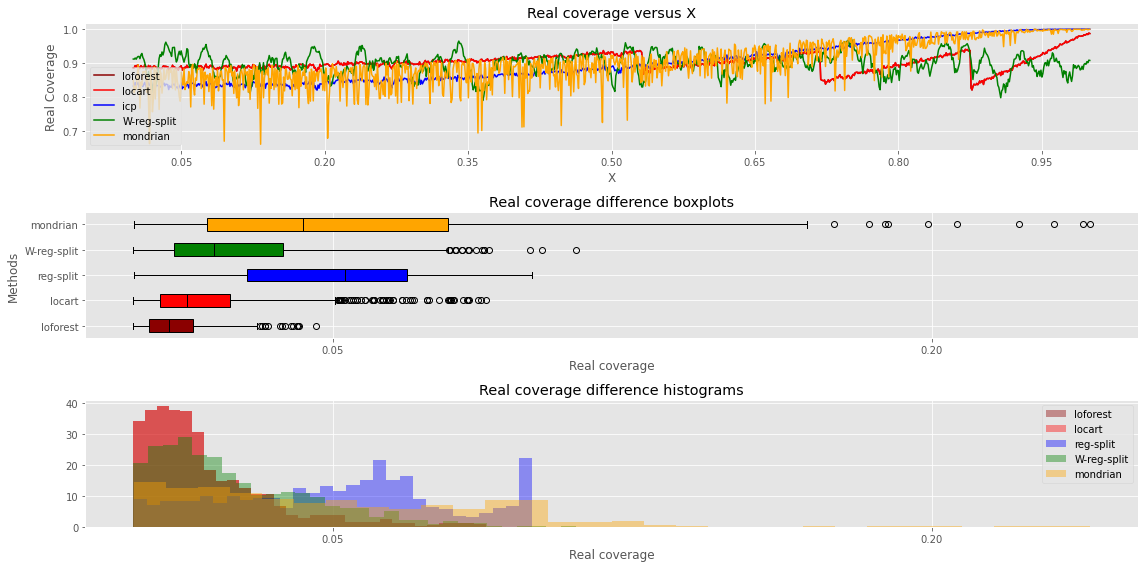

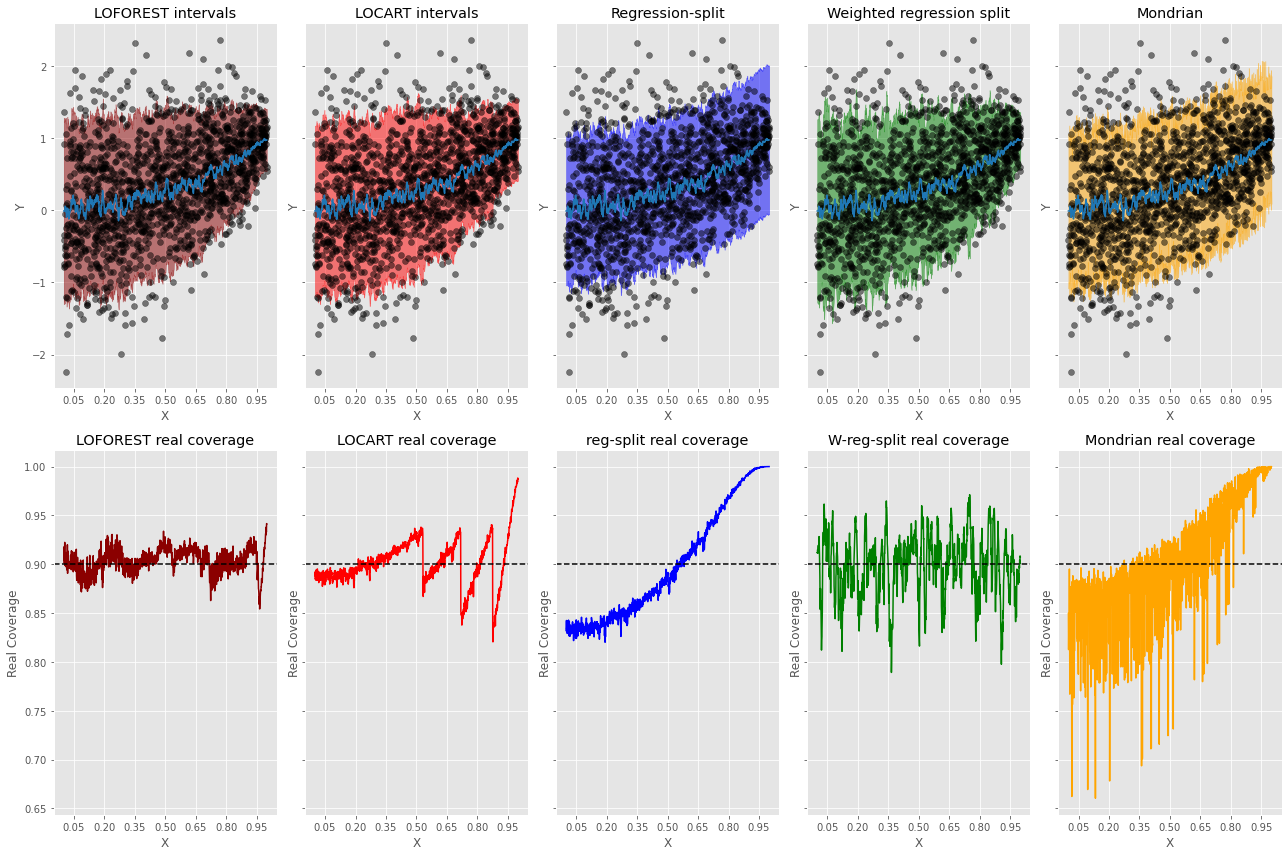

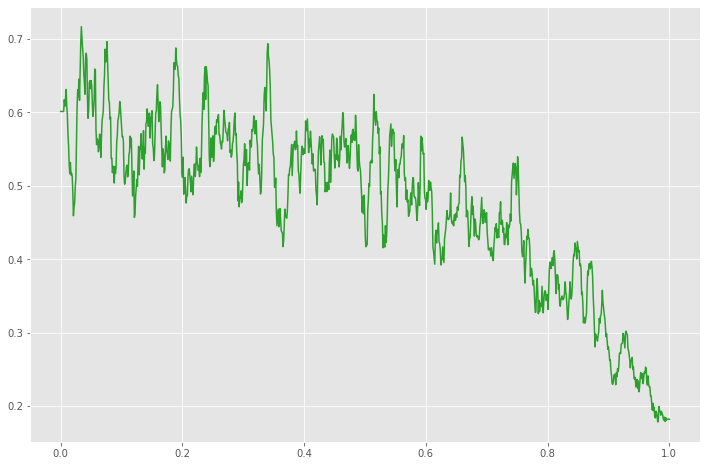

In [33]:
toy = run_toy_example(n = 15000, base_model = KNeighborsRegressor, n_neighbors = 75, random_seed = 950,
                       hetero_value = 1.05, x_lim = 1, test_size = 0.1, B_y = 10**4,
                      criterion = "squared_error", split_calib = False, min_samples_leaf = 150, prune = True, tune_knn = False)

In [34]:
toy

,Methods,smis,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance
0,LOFOREST,-2.544084,0.897333,2.021184,2.022556,0.010406
1,LOCART,-2.546306,0.898000,2.016141,2.015273,0.017489
2,Regresion split,-2.702919,0.899333,2.066983,2.066983,0.050421
3,Weighted regression split,-2.560861,0.894000,2.016410,2.026164,0.025196
4,Mondrian,-2.692704,0.901333,2.079738,2.082393,0.049250
